<a href="https://www.kaggle.com/code/yaroslavnaychuk/satellite-image-segmentation?scriptVersionId=110635733" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import warnings
warnings.filterwarnings('ignore') # if you need debug warnings, you can delete this cell

In [ ]:
%%capture 
# if you need debug warnings, you can delete this

# upgrade tensorflow and install requirements
!pip uninstall -y tensorflow-io
!pip uninstall -y tensorflow-transform
!pip uninstall -y tensorflow-cloud
!pip uninstall -y tfx-bsl
!pip uninstall -y tensorflow
!pip install tensorflow
!pip install seaborn
!pip install segmentation_models
!sudo apt install -y --allow-change-held-packages libcudnn8

import os
os._exit(00)

In [13]:
%%capture
import cv2
import matplotlib.patches as mpatches
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import segmentation_models as sm
import tqdm
# import cudf

from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from collections import Counter
from tensorflow.experimental.numpy import ravel
from tensorflow import stack, cast, int32, make_ndarray


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
def preprocess_data(img, mask, num_class):
    #img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)
    #merge some classes
    mask[mask == 7] = 6
    for i in range(8,16):
        mask[mask==i] = i - 1
    mask[mask == 13] = 12
    mask[mask == 14] = 13
    
    mask = to_categorical(mask, num_class)
    return (img, mask)

def trainGenerator(train_img_path, train_mask_path, num_class, aug=True, show_raw=False):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    if aug:
        image_datagen = ImageDataGenerator(**img_data_gen_args)
        mask_datagen = ImageDataGenerator(**img_data_gen_args)
    else:
        image_datagen = ImageDataGenerator()
        mask_datagen = ImageDataGenerator()
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        if show_raw:
            raw_img = np.copy(img)
            img, mask = preprocess_data(img, mask, num_class)
            img = np.stack((img, raw_img), axis=-1)
            yield (img, mask)
        else:
            img, mask = preprocess_data(img, mask, num_class)
            yield (img, mask)



def show_mask_with_label(batch, labels, _min, _max, alpha=1):
    values, counts = np.unique(batch, return_counts=True)
    counts = counts / (256*256)
    im = plt.imshow(batch, cmap='viridis', vmin = _min, vmax = _max, alpha=alpha)
    colors = [im.cmap(im.norm(value)) for value in values]
    patches = [mpatches.Patch(color=colors[i], label=labels[values[i]]) for i in range(len(values)) if counts[i]>0.005]
    plt.legend(handles=patches)


In [21]:
kaggle_path = '/kaggle/input/satelliteimagesegmentation/'
labels = ['background','industrial land',
          'urban residential','rural residential',
          'traffic land','paddy field','irrigated land', 'dry cropland',
          'garden plot','arbor woodland',
          'shrub land','natural grassland',
          'artificial grassland','river', 'lake','pond']

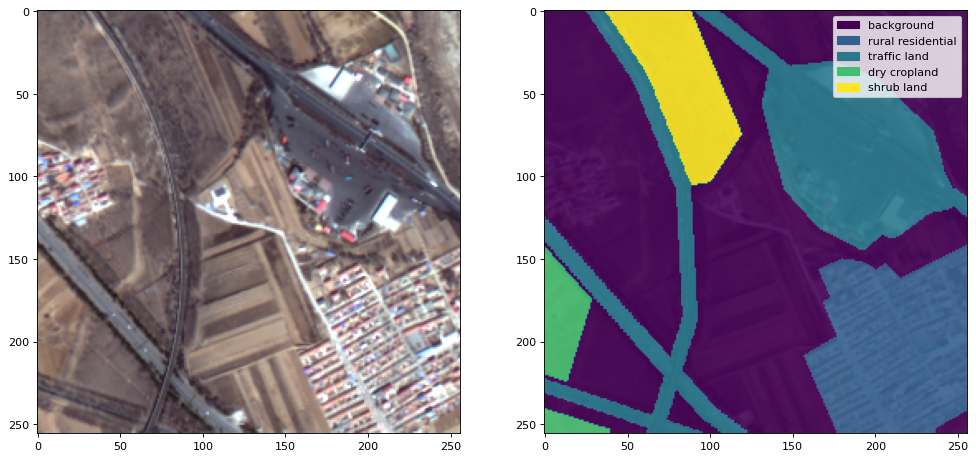

In [22]:
train_img_dir = kaggle_path + "data/data_for_keras_aug/train_images/train/"
train_mask_dir = kaggle_path + "data/data_for_keras_aug/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

img_list.sort()
msk_list.sort()

num_images = len(os.listdir(train_img_dir))
img_num = random.randint(0, num_images - 1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

_min, _max = np.amin(mask_for_plot), np.amax(mask_for_plot)

plt.figure(figsize=(15, 15), dpi=80)
plt.subplot(1,2,1)
plt.imshow(img_for_plot.astype('uint8'))

plt.subplot(1,2,2)
plt.imshow(img_for_plot.astype('uint8'))
plt.subplot(1,2,2)
show_mask_with_label(mask_for_plot, labels, _min, _max, alpha=0.9)  
plt.show()

In [ ]:
BACKBONE = 'mobilenet'
preprocess_input = sm.get_preprocessing(BACKBONE)
batch_size = 36
seed = 42
n_classes = 14
# scaler = MinMaxScaler()

In [ ]:
train_img_path = kaggle_path + "data/data_for_keras_aug/train_images/"
train_mask_path = kaggle_path + "data/data_for_keras_aug/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=n_classes)

val_img_path = kaggle_path + "data/data_for_keras_aug/val_images/"
val_mask_path = kaggle_path + "data/data_for_keras_aug/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=n_classes)

In [ ]:
def show_examples(generator):
    x, y = generator.__next__()
    for i in range(0,3):
        image = x[i]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = np.argmax(y[i], axis=2)
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.subplot(1,2,2)
        plt.imshow(mask, cmap='viridis')
        plt.show()
    return x, y

x, y = show_examples(train_img_gen)
x_val, y_val = show_examples(val_img_gen)

In [ ]:
num_train_imgs = len(os.listdir(train_img_path + "/train"))
num_val_images = len(os.listdir(val_img_path + "/val"))

steps_per_epoch = num_train_imgs // batch_size
val_steps_per_epoch = num_val_images // batch_size

IMG_HEIGHT = 256
IMG_WIDTH  = 256
IMG_CHANNELS = 3

In [ ]:
%%capture
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                     classes=n_classes, activation='softmax')
    model.compile('Nadam', loss=sm.losses.cce_jaccard_loss, metrics=[sm.metrics.iou_score])

In [ ]:
mkdir tmp # let's make tmp directory with model's checkpoints and weights

In [ ]:
cd tmp

In [ ]:
checkpoint_filepath = f'{BACKBONE}_14classes/checkpoint'
model.load_weights(checkpoint_filepath)

In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq = 25,
    monitor=sm.metrics.iou_score,
    mode='max')

model.fit(train_img_gen,
                steps_per_epoch=steps_per_epoch,
                epochs=25,
                verbose=1,
                validation_data=val_img_gen,
                validation_steps=val_steps_per_epoch,
                callbacks=[model_checkpoint_callback])

In [ ]:
#model.save_weights(f'{BACKBONE}_14classes.h5')

In [ ]:
eval_preds_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=n_classes, show_raw=True)

In [ ]:
test_image_batch, test_mask_batch = eval_preds_img_gen.__next__()
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 

test_pred_batch = model.predict(test_image_batch[:, :, :, :, 0])
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

IOU_keras = MeanIoU(num_classes=n_classes, ignore_class=[0])  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

img_num = random.randint(0, test_image_batch.shape[0]-4)

for i in range(0, 3):
    combined_data = np.array(list(np.unique(test_mask_batch_argmax[img_num+i])) + \
                         list(np.unique(test_pred_batch_argmax[img_num+i])))
    _min, _max = np.amin(combined_data), np.amax(combined_data)
    
    plt.figure(figsize=(15, 15), dpi=80)
    
    plt.subplot(1,3,1)
    plt.imshow(test_image_batch[:, :, :, :, 1][img_num+i].astype('uint8'))
    
    plt.subplot(1,3,2)
    plt.imshow(test_image_batch[:, :, :, :, 1][img_num+i].astype('uint8'))
    plt.subplot(1,3,2)
    show_mask_with_label(test_mask_batch_argmax[img_num+i], labels, _min, _max, alpha=0.9)   
    
    plt.subplot(1,3,3)
    show_mask_with_label(test_pred_batch_argmax[img_num+i], labels, _min, _max)
    plt.show()

## Label information of 14 classes:

* background - 0
* industrial land - 1
* urban residential - 2
* rural residential - 3
* traffic land - 4
* paddy field - 5
* farmland - 6
* garden plot - 7
* arbor woodland - 8
* shrub land - 9
* natural grassland - 10
* artificial grassland - 11
* river/lake - 12
* pond - 13

In [ ]:
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=n_classes, aug=False)
confusion_matrix = np.zeros((14, 14))
matrix = confusion_matrix

In [ ]:
for _ in tqdm.tqdm(range(val_steps_per_epoch)):
    image_batch, mask_batch = val_img_gen.__next__()
    x = model.predict(image_batch, verbose=0)
    
    y_true_batch = ravel(mask_batch.argmax(axis=3))
    y_pred_batch = ravel(x.argmax(axis=3))
    y_pairs = stack((y_true_batch, y_pred_batch), axis=-1)
    
    y_pairs = pd.DataFrame(y_pairs.numpy(), columns=['true', 'pred'])
    y_pairs['count'] = np.ones(len(y_pairs))
    grouped = y_pairs.groupby(by=['true', 'pred'],as_index=False).sum()
    grouped = grouped.to_numpy()
    
    for true, pred, count in grouped:
        matrix[int(true)][int(pred)] += count / grouped[:, 2].sum()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(matrix, annot=True, cmap='viridis', fmt='.2f')